# Dirichlet process demo

In this notebook we demonstrate the Dirchlet process, using the stick breaking construction. First we sample from the prior distribution $\pi = DP(\alpha, F_0)$, then we sample from the posterior distribution $p(F \,|, x)$ given a data set $x_1,\ldots, x_n$ that is drawn from a distribution that is different from the base distribution $F_0$.

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from IPython.display import clear_output
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline

Below we define three "helper" functions.

Given a parameter $\alpha$, the `stick_break` function returns a set of weights $w_1, w_2, \ldots, w_N$ given by

$$ w_i = 
\begin{cases} V_0 & \text{if $i=0$} \\
V_i (1-V_{i-1}) \cdots (1-V_{0}) & \text{if $i > 0$}
\end{cases} $$

where the random variables $V_0, V_1, \ldots, V_N$ are independent draws from a Beta$(1,\alpha)$ distribution. This gives a set of weights that sums to one (if $N$ is large).

In [2]:
def stick_break(alpha, N):
    V = np.random.beta(1, alpha, size=N)
    w = np.zeros(N)
    w[0] = V[0]
    d = 1
    for i in np.arange(1, N):
        d = d*(1-V[i-1])
        w[i] = V[i]*d
    return w/np.sum(w)

The next function, `sample_dirichlet_process(alpha, mu, sigma)` uses the stick breaking construction to draw a distribution $F$ from the prior $DP(\alpha, N(\mu, \sigma^2))$. To do this, we do two things:

1. Generate stick breaking weights $w_1, w_2, \ldots w_N$
2. Independently sample $s_1, s_2, \ldots, s_N$ from a $N(\mu,\sigma^2)$ distribution

After sorting the $s$ values, the resulting $F$ is then just a step function where 
there is a step of size $w_i$ at each value $s_i$.


In [3]:
def sample_dirichlet_process(alpha, mu, sigma):
    N = 1000
    s = np.random.normal(loc=mu, scale=sigma, size=N)
    w = stick_break(alpha, N)
    ind = np.argsort(s)
    s = s[ind]
    w = w[ind]
    return s, w

Our third function is `sample_dirichlet_process_posterior(x, alpha, mu, sigma)`, which 
samples from the posterior distribution $p(F \, |\, x_1, \ldots, x_n)$ when the prior distribution 
on $F$ is a Dirichlet process $DP(\alpha, N(\mu, \sigma^2))$. The sampling procedure 
is almost the same as for the prior, with a slight twist:

1. Generate stick breaking weights $w_1, w_2, \ldots w_N$ using the parameter $\tilde \alpha = \alpha + n$.

2. Independently sample $s_1, s_2, \ldots, s_N$ according to a mixture:
* With probability $\frac{\alpha}{\alpha + n}$, draw a sample from $F_0 = N(\mu,\sigma^2)$
* With probability $1 - \frac{\alpha}{\alpha + n}$, draw a sample from $\{x_1,\ldots, x_n\}$ (with replacement).

In [4]:
def sample_dirichlet_process_posterior(x, alpha, mu, sigma):
    N = 1000
    n = len(x)
    s0 = np.random.normal(loc=mu, scale=sigma, size=N)
    s1 = np.random.choice(x, size=N, replace=True)
    w = stick_break(alpha+n, N)
    b = np.random.binomial(1, p=alpha/(alpha+n), size=N)
    s = b*s0 + (1-b)*s1
    ind = np.argsort(s)
    s = s[ind]
    w = w[ind]
    return s, w

Now we demonstrate the Dirichlet process by sampling from the prior $DP(\alpha, N(\mu, \sigma^2))$ for different values of $\alpha$, $\mu$, and $\sigma^2$. Notice a few things as you watch the "movies":

* As $\alpha$ decreases, the stick is broken into fewer and fewer big pieces. Can you understand why?

* The sampled distribution $F$ is always a step function. Do you see why this is, from the code?

* For fixed $\alpha$, notice that the draws $F_i$ are centered around the CDF for the base distribution $N(\mu,\sigma^2)$, which we plot for reference. That is, if we were to run the movie for many frames $M$, and average the step functions to compute 
$\hat F(x) = \frac{1}{M} \sum_{i=1}^M F_i(x)$, it would line up very closely with the normal CDF shown. On assignment 2, you will prove that this is the case. 


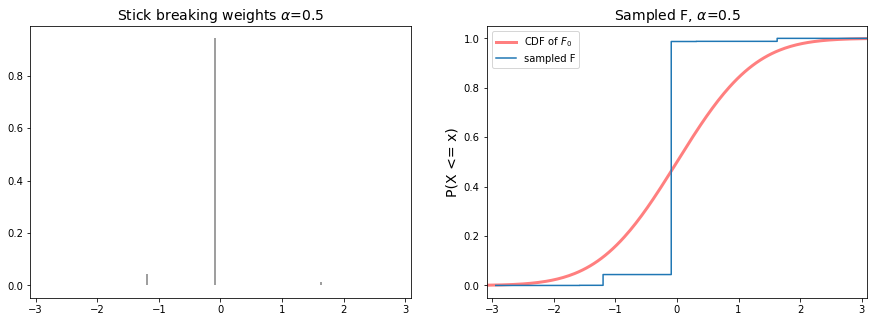

In [5]:
mu = 0
sigma = np.sqrt(1)

xmin, xmax = norm.ppf([.001, 1-.001], loc=mu, scale=sigma)
x = np.linspace(xmin, xmax, 200)

for alpha in np.flip([.5, 5, 10, 50, 100]):
    for trials in np.arange(10):
        s, w = sample_dirichlet_process(alpha, mu, sigma)
        F = np.cumsum(w)

        # Plot the result
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 2, figsize=(15, 5))
        ax[0].vlines(s, ymin=0, ymax=w, color='gray')
        ax[0].set_xlim(xmin, xmax)
        ax[0].set_title(r'Stick breaking weights $\alpha$=%.1f' % alpha, fontsize=14)
        ax[1].plot(x, norm.cdf(x, loc=mu, scale=sigma), 'r', linewidth=3, alpha=.5, 
                   label=r'CDF of $F_0$')
        ax[1].step(s, F, label='sampled F')
        ax[1].set_xlim(xmin, xmax)
        ax[1].set_ylabel('P(X <= x)', fontsize=14)
        ax[1].set_title(r'Sampled F, $\alpha$=%.1f' % alpha, fontsize=14)
        ax[1].legend()
        plt.show()
        sleep(.95)

Next, we sample from the posterior Dirichlet process, for a range of values 
of $\alpha$. Our data set is a small number of samples from a $N(5,3)$ distribution,. Note that the base distribution $F_0$, which is $N(0,1)$, is very different from the true distribution $N(5,3)$. So, for large $\alpha$ the posterior is very far from the true model; for small $\alpha$ the posterior becomes closer to the empirical distribution of the data.

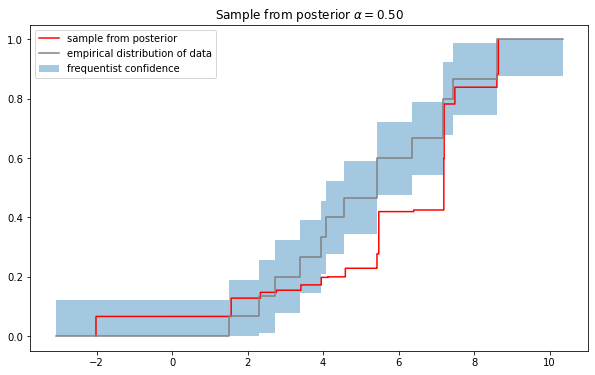

In [9]:
n = 15
mu = 5
sigma = np.sqrt(3)
eps = (1/(2*n))*np.log(2/.05) # width of frequentist interval

mu0 = 0
sigma0 = np.sqrt(1)

x = np.random.normal(loc=mu, scale=sigma, size=n)

xmin, xmax = norm.ppf([.001, 1-.001], loc=mu, scale=sigma)
xmin0, xmax0 = norm.ppf([.001, 1-.001], loc=mu0, scale=sigma0)
xmin = np.min([xmin, xmin0])
xmax = np.max([xmax, xmax0])

s0 = np.linspace(xmin, xmax, 200)
Fhat = np.zeros(len(s0))
for i in np.arange(len(s0)):
    Fhat[i] = np.mean(x <= s0[i])
    
for alpha in np.flip([.5, 5, 10, 50, 100]):
    
    for samples in np.arange(10):
        s, w = sample_dirichlet_process_posterior(x, alpha=alpha, mu=mu0, sigma=sigma0)
        
        clear_output(wait=True)
        plt.figure(figsize=(10,6))
        plt.step(s, np.cumsum(w), label='sample from posterior', color='red')
        plt.step(s0, Fhat, color='gray', label='empirical distribution of data')
        plt.fill_between(s0, np.maximum(Fhat - eps, 0), np.minimum(Fhat + eps, 1), 
                         step="pre", alpha=0.4, label='frequentist confidence')
        plt.title(r'Sample from posterior $\alpha=$%.2f' % alpha)
        plt.legend()
        plt.show()
        sleep(.5)

Again, notice a few things as you watch the "movies":

* As $\alpha$ decreases, the sampled distribution becomes more and more 
like the empirical distribution of the data. Can you understand why? How does $\alpha$ control the "strength" of the prior distribution?

* The sampled distribution $F$ is again always a step function. This is because 
of conjugacy--the posterior is another Dirichlet process.

* For fixed $\alpha$, notice that the draws $F_i$ are centered around a 
distribution that is different from the true distribution of the data, especially for large $\alpha$. If we
were to average many frames of the movie and compute
$\hat F(x) = \frac{1}{M} \sum_{i=1}^M F_i(x)$, it would line up very closely with 
the posterior mean. Can you say what this posterior mean is?

* Can you see that the uncertainty (variance) in the Bayesian posterior is very different from the uncertainty in the true distribution using a frequentist confidence interval around the empirical distribution?

